Fallstudie:<br> 
**Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehr für Online-Einkäufe**


In [11]:
import pandas as pd
pd.option_context('mode.use_inf_as_na', True)
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid',)
color_pal = sns.color_palette("muted")
sns.set_palette(color_pal)
sns.set_context("paper")

%matplotlib inline

# Business understanding
**Aktuelle Situation:**<br>
- Einzelhandelsunternehmen hat Verträge mit 4 versch. payment service provider (PSP) für Online-Kreditkartenzahlungen
- Auswahl eines PSPs für eine Überweisung erfolgt auf Basis eines fixen Regelwerks
- Ausfallrate an Online-Kreditkartenzahlungen ist hoch
- Konsequenz: hohe Kosten für das Unternehmen und unzufriedene Kunden

**Geschäftsziele:**<br>
- Ablösen des fixen, manuellen Regelwerks durch ein Prognosemodell zur Auswahl eines PSPs für eine Zahlung
- Verbesserung der Erfolgsrate der Transaktionen
- Reduzierung der Transaktionskosten

**Erfolgskriterien:**<br>
- höhere Erfolgsrate der Transaktionen
- und niedrigere Transaktionskosten gegenüber der aktuellen Situation

# Data understanding

## Collect initial data
**Hauptdatensatz:**<br>
Initialer Datensatz vom Januar und Februar 2019 mit den Kreditkartentransaktionen der DACH Länder<br>

**Kostendaten:**<br>

In [2]:
# transactions
df_t_in = pd.read_excel("../data/01_raw/PSP_Jan_Feb_2019.xlsx").set_index(keys="Unnamed: 0", drop=True)

In [3]:
df_t_in.head()

,tmsp,country,amount,success,PSP,3D_secured,card
Unnamed: 0,,,,,,,
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [4]:
# cost data
cost_dict = {"PSP_name": ["Moneycard", "Goldcard", "UK_Card", "Simplecard"], 
             "fee_success_EUR": [5, 10, 3, 1], 
             "fee_failed_EUR": [2, 5, 1, 0.5]}
df_cost_in = pd.DataFrame(cost_dict, columns=["PSP_name", "fee_success_EUR", "fee_failed_EUR"])

In [5]:
df_cost_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PSP_name         4 non-null      object 
 1   fee_success_EUR  4 non-null      int64  
 2   fee_failed_EUR   4 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 228.0+ bytes


## Describe data
6 unabhängige Variablen und 1 Zielvariable (success)<br>
Datenformat korrekt erkannt<br>
keine fehlenden Werte<br>

In [6]:
df_t_in.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


In [7]:
df_t_in.describe()

,tmsp,amount,success,3D_secured
count,50410,50410.000000,50410.000000,50410.000000
mean,2019-01-29 16:28:52.923269120,202.395715,0.202896,0.238266
min,2019-01-01 00:01:11,6.000000,0.000000,0.000000
25%,2019-01-14 12:00:36.249999872,133.000000,0.000000,0.000000
50%,2019-01-30 15:20:07.500000,201.000000,0.000000,0.000000
75%,2019-02-13 01:09:50.500000,269.000000,0.000000,0.000000
max,2019-02-28 23:48:19,630.000000,1.000000,1.000000
std,NaN,96.274730,0.402160,0.426027


In [8]:
# raw x- and y-variables
x_raw = ["tmsp", "country", "amount", "PSP", "3d_secured", "card"]
y_raw = ["success"]

## Explore data

In [9]:
# plot dimensions
plot_width = 15
plot_height = 5
palette_success ={0: color_pal[1], 1: color_pal[2]}

# masking df_t_in successful and failed
mask_success = df_t_in["success"] == 1
mask_fail = df_t_in["success"] == 0

### Verteilung über Histogramme

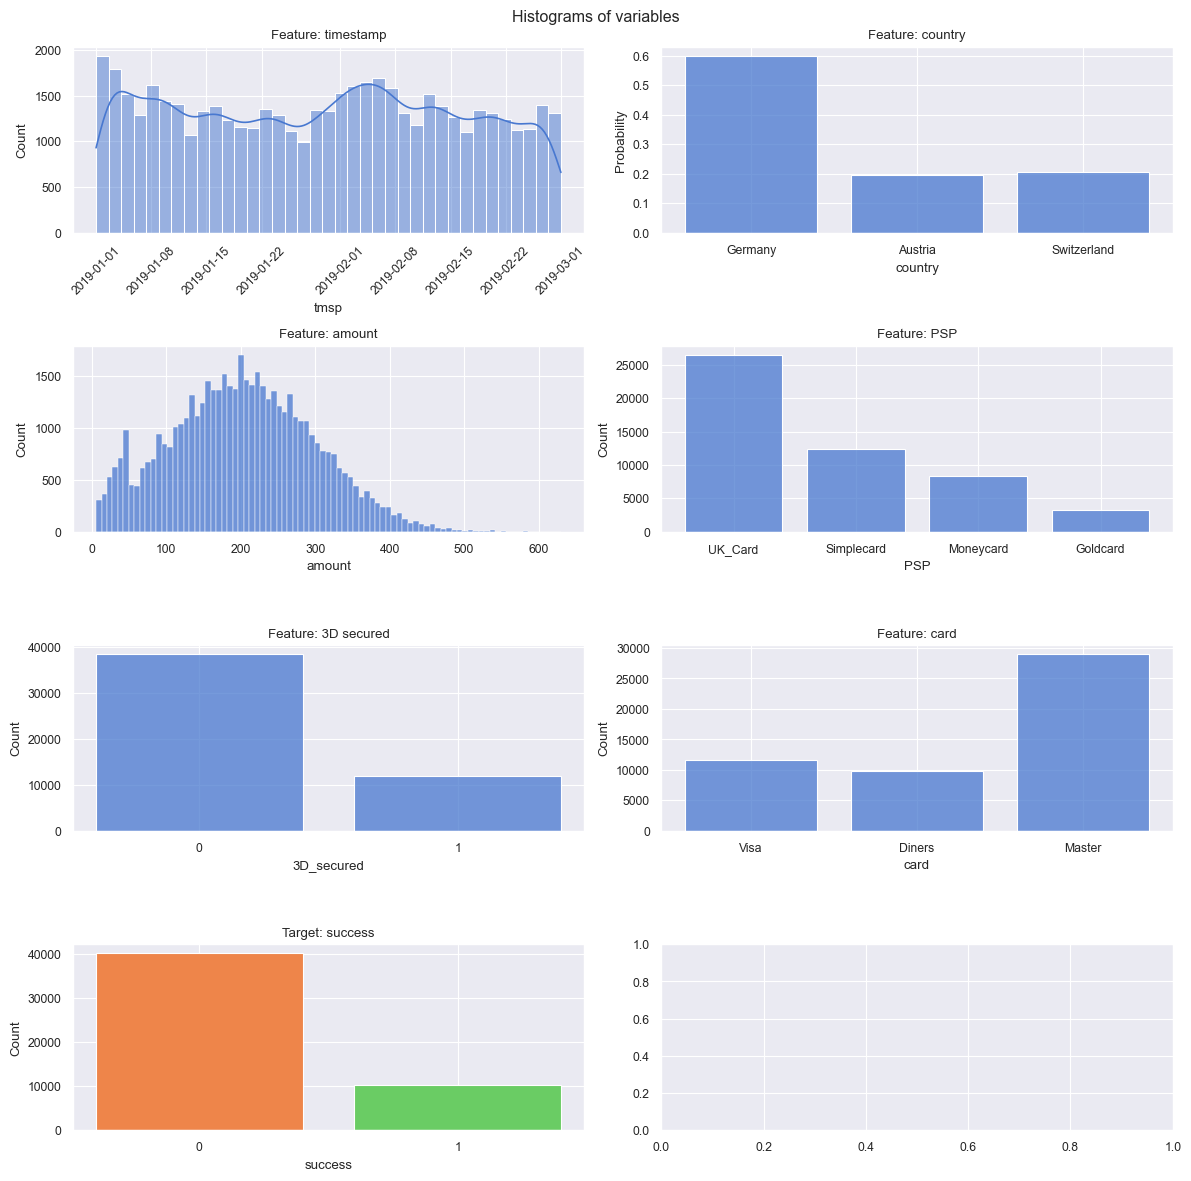

In [19]:
fig, axs = plt.subplots(4,2, figsize=(12, 12), sharex=False, tight_layout=True)

# Timestamp
sns.histplot(df_t_in, x="tmsp", stat="count", ax=axs[0, 0])
axs[0, 0].set_title("Feature: timestamp")
for label in axs[0, 0].get_xticklabels():
    label.set_rotation(45)

# Country
sns.histplot(df_t_in, x="country", discrete=True, shrink=.8, stat="count", ax=axs[0, 1])
axs[0, 1].set_title("Feature: country")

# Amount
sns.histplot(df_t_in, x="amount", stat="count", ax=axs[1, 0])
axs[1, 0].set_title("Feature: amount")

# PSP
sns.histplot(df_t_in, x="PSP", discrete=True, shrink=.8, stat="count", ax=axs[1, 1])
axs[1, 1].set_title("Feature: PSP")

# 3d_secured
sns.histplot(df_t_in, x="3D_secured", discrete=True, shrink=.8, stat="count", ax=axs[2, 0])
axs[2, 0].set_xticks(range(0,2))
axs[2, 0].set_title("Feature: 3D secured")

# card
sns.histplot(df_t_in, x="card", discrete=True, shrink=.8, stat="count", ax=axs[2, 1])
axs[2, 1].set_title("Feature: card")

# card
sns.histplot(df_t_in, x="success", discrete=True, shrink=.8, stat="count", ax=axs[3, 0])
axs[3, 0].set_xticks(range(0,2))
axs[3, 0].set_title("Target: success")
axs[3, 0].patches[0].set_facecolor(color_pal[1])
axs[3, 0].patches[1].set_facecolor(color_pal[2])

plt.subplots_adjust(hspace=0.3, top = 0.93, bottom = 0.02) 
fig.suptitle("Histograms of variables") 
plt.show() 
plt.close()

> Amount muss genauer angeschaut werden, da es hier einige Ausreißer nach oben gibt

<Figure size 1500x500 with 0 Axes>

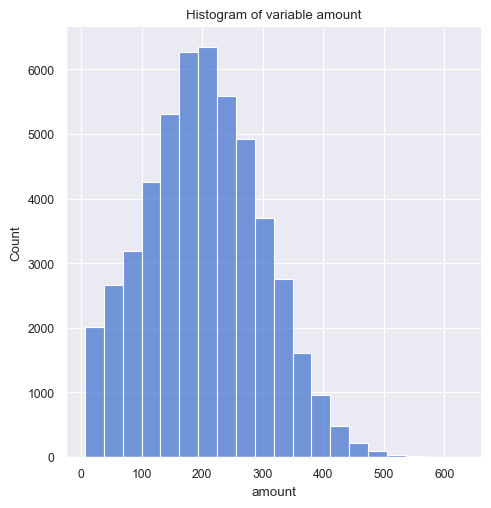

In [22]:
plt.figure(figsize=(plot_width, plot_height))
sns.displot(df_t_in, x="amount", bins=20)
plt.title("Histogram of variable amount")
plt.show()
plt.close()

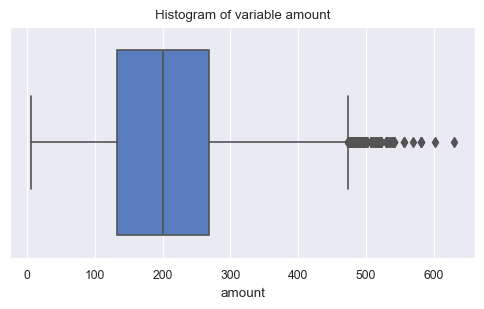

In [30]:
plt.figure(figsize=(6, 3))
sns.boxplot(x="amount", orient="h", data=df_t_in)
plt.title("Histogram of variable amount")
plt.show()
plt.close()

> Bei Amount > 500 den Wert auf 500 setzen, da ansonsten nicht genügend Werte zur Verfügung stehen

### Korrelation überprüfen

## Verify data quality